## 知识蒸馏-CTT teacher->DGRU student

In [1]:
import copy
import math
import torch
import pickle
import numpy as np
import pandas as pd
import geatpy as ea
from tqdm import tqdm
from torch import nn
from torch import optim
from fill.hot_filling import hot_fill
from fill.neighbour_filling import neighbour_fill
from filter.w_mean_filter import *
from filter.rssi_guass_filter import filter_guass
from filter.kalman_filter import filter_kalman
import torch.nn.functional as F
import matplotlib.pyplot as plt
import utils.calculate_param as cp
from dataset import data_read
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

/Users/frank/Desktop/jupyter/RFID_TRANS/filter/


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### 硬件设备准备

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 加载数据集 近邻填充+高斯滤波

In [3]:
X_train_0, y_train_0 = data_read.load_data('train')
X_test_0, y_test_0 = data_read.load_data('test')

In [4]:
X_train_neighbour = [neighbour_fill(xi) for xi in X_train_0]
X_test_neighbour = [neighbour_fill(xi) for xi in X_test_0]
X_train_guass = [filter_guass(xi) for xi in X_train_neighbour]
X_test_guass = [filter_guass(xi) for xi in X_test_neighbour]
X_train_guass = np.array(X_train_guass)
X_test_guass = np.array(X_test_guass)

X_train_guass.shape

(2000, 50)

In [5]:
X_train = torch.from_numpy(X_train_guass).float().to(device) # [len * feature]
y_train = torch.from_numpy(y_train_0).float().to(device)
X_test = torch.from_numpy(X_test_guass).float().to(device) # [len * feature]
y_test = torch.from_numpy(y_test_0).float().to(device)

X_train.shape


torch.Size([2000, 50])

In [6]:
train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=100, shuffle=False)
test_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=100, shuffle=False)

### 定义教师模型-CTT

In [16]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out=nn.Linear(960, 50)

    def forward(self, x):
        x= self.conv1(x)
        # print(x.shape)
        x= self.conv2(x)
        # print(x.shape)
        x= x.view(-1, x.size(0) * x.size(1) * x.size(2))
        # print(x.shape)
        out = self.out(x)
        return out


# 位置编码类
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        out = x + self.pe[:x.size(0), :]
        return out


# 教师模型类
class TeacherTransformer(nn.Module):
    def __init__(self):
        super(TeacherTransformer, self).__init__()
        self.cnn = CNN()
        self.d_model = 128  # 词向量维度
        self.embedding_enc = nn.Linear(50, self.d_model)
        self.embedding_dec = nn.Linear(2, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        self.Transformer_layer = nn.Transformer(d_model=128, num_encoder_layers=3, num_decoder_layers=3, batch_first=True)
        self.FC_layer = nn.Linear(128, 2)

    def forward(self, src, tgt):
        # rssi进行cnn特征提取
        src = src.unsqueeze(0)
        src = self.cnn(src)
        # print(src.shape)
        # 使用线性层代替embedding
        src = self.embedding_enc(src).unsqueeze(0)
        tgt = self.embedding_dec(tgt).unsqueeze(0)
        src = self.pos_encoding(src)
        out = self.Transformer_layer(src, tgt)
        out = self.FC_layer(out)
        return out


### 教师模型设置

In [17]:
model = TeacherTransformer().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)

### 教师模型信息

In [18]:
# 输出教师模型的参数信息-380w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                                                 Param #
TeacherTransformer                                                     --
├─CNN: 1-1                                                             --
│    └─Sequential: 2-1                                                 --
│    │    └─Conv2d: 3-1                                                150
│    │    └─ReLU: 3-2                                                  --
│    │    └─MaxPool2d: 3-3                                             --
│    └─Sequential: 2-2                                                 --
│    │    └─Conv2d: 3-4                                                888
│    │    └─ReLU: 3-5                                                  --
│    │    └─MaxPool2d: 3-6                                             --
│    └─Linear: 2-3                                                     48,050
├─Linear: 1-2                                                          6,528
├─Linear:

### 教师模型训练

In [19]:
%%time

best_loss = 100000
best_epoch = 0
for epoch in range(150):
    epoch_loss = 0
    for X, y in train_data_loader:  # enc_inputs : [len * feature]->[2000 * 50]
        # print(X.shape)  # [100 * 50]
        # print(y.shape)  # [100 * 50]
        outputs = model(X, y)
        outputs = outputs.squeeze()  # [100 * 2]
        # print(outputs.shape)
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/ctt_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 52.086514
Epoch: 0002 loss = 41.168497
Epoch: 0003 loss = 19.751831
Epoch: 0004 loss = 12.371386
Epoch: 0005 loss = 12.730629
Epoch: 0006 loss = 11.813145
Epoch: 0007 loss = 7.076452
Epoch: 0008 loss = 6.586562
Epoch: 0009 loss = 5.622090
Epoch: 0010 loss = 6.511099
Epoch: 0011 loss = 4.304690
Epoch: 0012 loss = 5.324989
Epoch: 0013 loss = 3.563148
Epoch: 0014 loss = 3.082420
Epoch: 0015 loss = 3.904428
Epoch: 0016 loss = 3.803955
Epoch: 0017 loss = 3.592172
Epoch: 0018 loss = 2.870813
Epoch: 0019 loss = 2.794926
Epoch: 0020 loss = 3.193561
Epoch: 0021 loss = 3.127644
Epoch: 0022 loss = 3.276405
Epoch: 0023 loss = 3.539851
Epoch: 0024 loss = 4.363390
Epoch: 0025 loss = 5.728002
Epoch: 0026 loss = 6.276980
Epoch: 0027 loss = 6.651875
Epoch: 0028 loss = 3.383817
Epoch: 0029 loss = 3.302269
Epoch: 0030 loss = 2.934210
Epoch: 0031 loss = 2.245820
Epoch: 0032 loss = 1.753130
Epoch: 0033 loss = 2.176328
Epoch: 0034 loss = 1.671542
Epoch: 0035 loss = 1.597221
Epoch: 0036 lo

### 教师模型评估

In [20]:
model = TeacherTransformer().to(device)
# 暂存教师模型为teacher_model
teacher_model = model
model.load_state_dict(torch.load('./result/ctt_weight.pth'))
model.eval()

pxy_all = []
y_all = []
for X, y in test_data_loader:
    pxy = model(X, y)
    pxy = pxy.cpu().detach().numpy().squeeze(0)
    y = y.cpu().detach().numpy()
    pxy_all.append(pxy)
    y_all.append(y)

# 计算指标
pxy_all = np.array(pxy_all).reshape(-1, 2)
y_all = np.array(y_all).reshape(-1, 2)
mae = mean_absolute_error(y_all, pxy_all)
mse = mean_squared_error(y_all, pxy_all)
rmse = mse ** 0.5
evs = explained_variance_score(y_all, pxy_all)
r2 = r2_score(y_all, pxy_all)

mmax = 0
mmin = 10000
for i in range(len(pxy_all)):
    mmax = max(mean_absolute_error(y_all[i], pxy_all[i]), mmax)
    mmin = min(mean_absolute_error(y_all[i], pxy_all[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})

y_teacher = y_all[:20]
pxy = pxy_all[:20]
coor1 = pd.DataFrame(y_teacher)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_ctt.csv')
print(coor)

{'mae': 0.083563276, 'mse': 0.009755993, 'rmse': 0.09877243168988666, 'evs': 0.998113363981247, 'r2': 0.9952863212685581, 'mmax': 0.23729467, 'mmin': 0.017131537}
       X     y        PX        Py
0   0.21  3.47  0.245147  3.529120
1   1.13  1.96  1.196976  2.037458
2   3.38  2.58  3.509076  2.693891
3   4.07  2.72  4.230471  2.845829
4   1.58  2.47  1.647689  2.543962
5   3.43  1.61  3.568917  1.697960
6   1.22  0.74  1.316422  0.784526
7   2.33  1.97  2.433043  2.037741
8   0.33  3.56  0.355676  3.628693
9   3.53  4.28  3.655198  4.490645
10  4.42  3.69  4.636249  3.866905
11  3.67  0.34  3.831290  0.339497
12  2.57  0.37  2.694048  0.397630
13  3.14  3.22  3.244254  3.332000
14  4.76  3.34  4.918339  3.465530
15  1.70  3.71  1.770001  3.785635
16  3.50  1.20  3.626587  1.278121
17  0.68  4.65  0.639596  4.752783
18  1.09  4.59  1.075465  4.723710
19  0.25  3.70  0.270644  3.772177


### 教师模型定位效果可视化

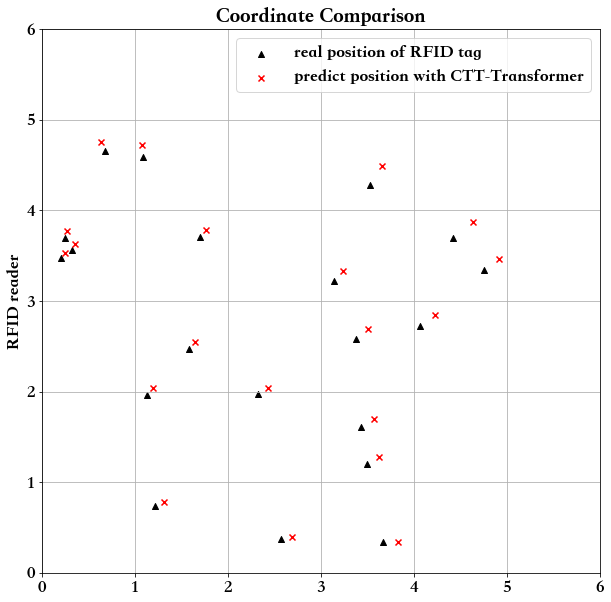

In [21]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_teacher[:, 0], y_teacher[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with CTT-Transformer')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_ctt.jpg', dpi=750, bbox_inches = 'tight')

### 定义学生模型-GRU模型

In [22]:
class StudentGRU(nn.Module):
    def __init__(self):
        super(StudentGRU, self).__init__()
        self.time_step = 50
        self.input_dim = 1
        self.h_dim = 100
        self.gru_layers = 2
        self.GRU_layer = nn.GRU(self.input_dim, self.h_dim, self.gru_layers, batch_first=True)
        self.FC = nn.Linear(self.h_dim, 2)


    def forward(self, x):
        batch, time_step, x_dim = x.size()
        h0 = torch.zeros((2, batch, self.h_dim)).to(device)
        output, hn = self.GRU_layer(x, h0)
        res = hn.squeeze(0)
        res = self.FC(res)
        return res

### 学生模型设置

In [23]:
# 从头先训练一下学生模型
model = StudentGRU().to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### 学生模型信息

In [24]:
# 输出学生模型的参数信息-9w参数
cp.get_summary(model, input_size=None)

torchinfo信息如下：
Layer (type:depth-idx)                   Param #
StudentGRU                               --
├─GRU: 1-1                               91,500
├─Linear: 1-2                            202
Total params: 91,702
Trainable params: 91,702
Non-trainable params: 0


### 学生模型训练

In [26]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(100):
    epoch_loss = 0
    for X, y in train_data_loader:
        outputs = model(X.unsqueeze(2))
        outputs = outputs[0]
        loss = criterion(outputs, y)
        loss_num = loss.item()
        epoch_loss += loss_num
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/student_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 19.608995
Epoch: 0002 loss = 16.023807
Epoch: 0003 loss = 11.419941
Epoch: 0004 loss = 8.835409
Epoch: 0005 loss = 7.107397
Epoch: 0006 loss = 6.221930
Epoch: 0007 loss = 5.351082
Epoch: 0008 loss = 4.865790
Epoch: 0009 loss = 4.473491
Epoch: 0010 loss = 4.039392
Epoch: 0011 loss = 3.970814
Epoch: 0012 loss = 3.859847
Epoch: 0013 loss = 3.782208
Epoch: 0014 loss = 3.679907
Epoch: 0015 loss = 3.543730
Epoch: 0016 loss = 3.479732
Epoch: 0017 loss = 3.315970
Epoch: 0018 loss = 3.552643
Epoch: 0019 loss = 3.402659
Epoch: 0020 loss = 3.251538
Epoch: 0021 loss = 3.278779
Epoch: 0022 loss = 3.238456
Epoch: 0023 loss = 3.341459
Epoch: 0024 loss = 3.436113
Epoch: 0025 loss = 3.666515
Epoch: 0026 loss = 3.590277
Epoch: 0027 loss = 3.717018
Epoch: 0028 loss = 3.310680
Epoch: 0029 loss = 3.164450
Epoch: 0030 loss = 3.158495
Epoch: 0031 loss = 3.295585
Epoch: 0032 loss = 3.434649
Epoch: 0033 loss = 3.392101
Epoch: 0034 loss = 3.152268
Epoch: 0035 loss = 3.135858
Epoch: 0036 loss 

### 学生模型评估

In [27]:
model = StudentGRU()
# 暂存不加蒸馏学生模型为student_model
student_model = model

model.load_state_dict(torch.load('./result/student_weight.pth'))
model.eval()

pxy = model(X_test.unsqueeze(2))
pxy = pxy.cpu().detach().numpy()
pxy = pxy[0]
# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})


{'mae': 0.30270064, 'mse': 0.17550878, 'rmse': 0.4189376830359982, 'evs': 0.9147590696811676, 'r2': 0.9139824521964277, 'mmax': 1.4403541, 'mmin': 0.012073815}


### 学生模型定位效果可视化

In [28]:
y_test = np.array(y_test)
y_student = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_student)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_student.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.503097,3.752244
1,1.13,1.96,1.097255,0.900065
2,3.38,2.58,3.108394,1.884070
3,4.07,2.72,4.004938,3.078904
4,1.58,2.47,1.572033,1.594614
5,3.43,1.61,2.837763,1.370729
6,1.22,0.74,1.334321,0.908371
7,2.33,1.97,2.149880,1.307962
8,0.33,3.56,0.402117,4.007015
9,3.53,4.28,3.468775,4.058448


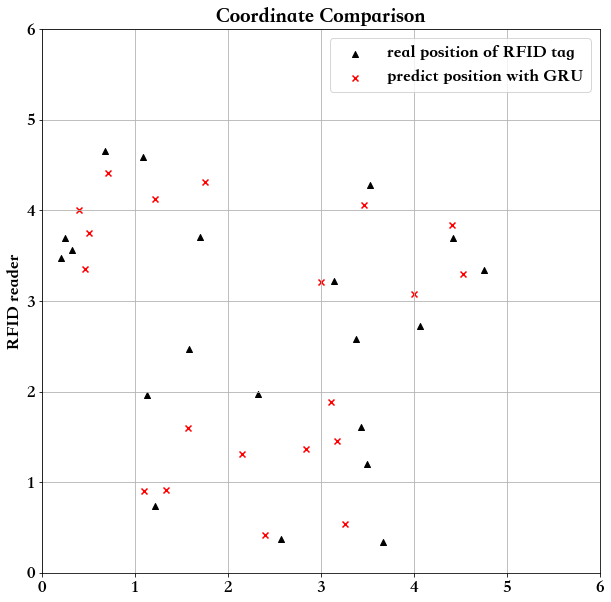

In [29]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_student[:, 0], y_student[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with GRU')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_student.jpg', dpi=750, bbox_inches = 'tight')

### 知识蒸馏准备与设置

In [30]:
# 准备预训练好的教师模型
teacher_model.eval()

# 准备新的学生模型
model = StudentGRU().to(device)

# 蒸馏温度
T = 7

# 参数设置
# hard_loss
hard_loss = nn.MSELoss()
# soft_loss kl散度
soft_loss = nn.KLDivLoss(reduction='batchmean')

alpha = 0.5
beta = 0.7
m = 0.9

# 回归分析的损失函数设置 = 平滑l1loss + beta * 范围loss
# loss = smoothl1loss + alpha * boundloss
loss1 = nn.SmoothL1Loss()
loss2 = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### 知识蒸馏训练

In [31]:
%%time
best_loss = 100000
best_epoch = 0
for epoch in range(150):
    epoch_loss = 0
    for X, y in train_data_loader:
        X, y = X.to(device), y.to(device)
        # 教师模型预测
        with torch.no_grad():
            teacher_outputs = teacher_model(X, y)
            teacher_outputs = teacher_outputs.squeeze(0)
        # 学生模型预测
        student_outputs = model(X.unsqueeze(2))
        student_outputs = student_outputs[0]
        # 回归损失
        ls = loss2(student_outputs, y)
        lt = loss2(teacher_outputs, y)
        loss = loss1(student_outputs, y)  # smooth loss
        if ls.item() + m > lt.item():  # bound loss
            loss += beta * ls
        # 反向传播,优化权重
        optimizer.zero_grad()
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, './result/distillation_weight.pth')

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(epoch_loss))

# 打印最佳的结果
print('best_loss::|',best_loss,'---best_epoch::|',best_epoch)


Epoch: 0001 loss = 88.677766
Epoch: 0002 loss = 42.684846
Epoch: 0003 loss = 37.794860
Epoch: 0004 loss = 30.749889
Epoch: 0005 loss = 24.426060
Epoch: 0006 loss = 20.801263
Epoch: 0007 loss = 16.946909
Epoch: 0008 loss = 12.652410
Epoch: 0009 loss = 9.702937
Epoch: 0010 loss = 7.205090
Epoch: 0011 loss = 7.366004
Epoch: 0012 loss = 6.231112
Epoch: 0013 loss = 5.420766
Epoch: 0014 loss = 4.912076
Epoch: 0015 loss = 4.659806
Epoch: 0016 loss = 4.394618
Epoch: 0017 loss = 4.198837
Epoch: 0018 loss = 4.058479
Epoch: 0019 loss = 3.955757
Epoch: 0020 loss = 3.895028
Epoch: 0021 loss = 3.896154
Epoch: 0022 loss = 3.884773
Epoch: 0023 loss = 3.834928
Epoch: 0024 loss = 3.799754
Epoch: 0025 loss = 3.776893
Epoch: 0026 loss = 3.793406
Epoch: 0027 loss = 3.817404
Epoch: 0028 loss = 3.818651
Epoch: 0029 loss = 3.784078
Epoch: 0030 loss = 3.757012
Epoch: 0031 loss = 3.732568
Epoch: 0032 loss = 3.719560
Epoch: 0033 loss = 3.772239
Epoch: 0034 loss = 3.783303
Epoch: 0035 loss = 3.776355
Epoch: 0036 

### 蒸馏模型评估

In [32]:
model = StudentGRU()
model.load_state_dict(torch.load('./result/distillation_weight.pth'))
model.eval()

pxy = model(X_test.unsqueeze(2))
pxy = pxy.cpu().detach().numpy()
pxy = pxy[0]
# 计算指标
mae = mean_absolute_error(y_test, pxy)
mse = mean_squared_error(y_test, pxy)
rmse = mse ** 0.5
evs = explained_variance_score(y_test, pxy)
r2 = r2_score(y_test, pxy)

mmax = 0
mmin = 10000
for i in range(len(pxy)):
    mmax = max(mean_absolute_error(y_test[i], pxy[i]), mmax)
    mmin = min(mean_absolute_error(y_test[i], pxy[i]), mmin)

print({'mae': mae, 'mse': mse, 'rmse': rmse, 'evs': evs, 'r2': r2, 'mmax': mmax, 'mmin': mmin})


{'mae': 0.2980882, 'mse': 0.17965937, 'rmse': 0.4238624383071305, 'evs': 0.9168875515460968, 'r2': 0.9119243396089238, 'mmax': 1.3975558, 'mmin': 0.02220583}


### 蒸馏模型定位效果可视化

In [112]:
y_distill = y_test[:20]
pxy = pxy[:20]
coor1 = pd.DataFrame(y_distill)
coor1.columns = ['X', 'y']

coor2 = pd.DataFrame(pxy)
coor2.columns = ['PX', 'Py']

coor = pd.concat([coor1, coor2], axis=1)
coor.to_csv('./result/coordinate_all_distill.csv')
coor

,X,y,PX,Py
0,0.21,3.47,0.534461,3.935997
1,1.13,1.96,1.074011,1.070417
2,3.38,2.58,3.129016,2.307425
3,4.07,2.72,4.000291,3.315290
4,1.58,2.47,1.524554,1.962826
5,3.43,1.61,2.828833,1.709573
6,1.22,0.74,1.269941,1.039838
7,2.33,1.97,2.096336,1.697928
8,0.33,3.56,0.415309,4.165952
9,3.53,4.28,3.522856,4.253444


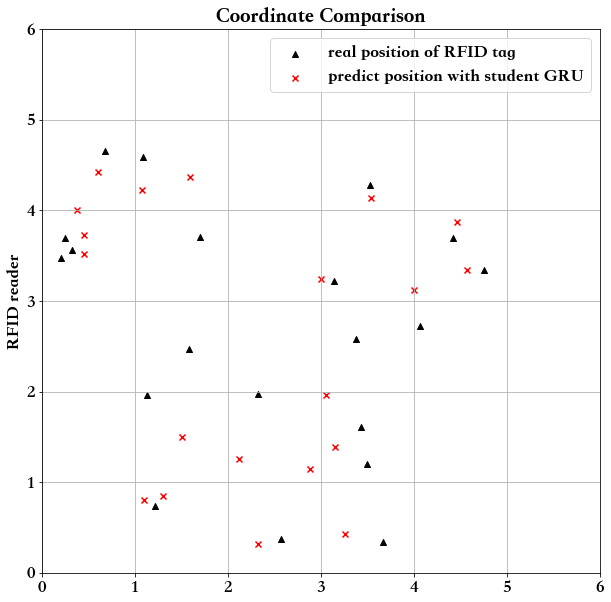

In [101]:
plt.figure(figsize=[10, 10])
plt.xlim((0, 6))
plt.ylim((0, 6))
plt.ylabel('RFID reader')
plt.title('Coordinate Comparison')
# 画图-标准坐标
plt.scatter(y_distill[:, 0], y_distill[:, 1], c='black', marker='^', label='real position of RFID tag')

# 画图-预测EA坐标
plt.scatter(pxy[:, 0], pxy[:, 1], c='red', marker='x', label = 'predict position with student GRU')

plt.legend()
plt.grid('True')
plt.savefig('./result/compare_coordinate_distill.jpg', dpi=750, bbox_inches = 'tight')

|### 定义问题类

In [19]:
class MOEA(ea.Problem):
    def __init__(self, train_data_loader, test_data_loader):
        name = 'MOEA'
        M = 1 # 初始化M（目标维数）
        maxormins = [-1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes 0-连续
        lb = [5, 0.1] # 决策变量下界
        ub = [10, 0.9] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.train_data_loader = train_data_loader
        self.test_data_loader = test_data_loader


    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 1)) # 初始化种群个体目标函数值列向量
        def subAimFunc(i):
            epochs, alpha = int(Vars[i, 0]), float(Vars[i, 1])
            print(epochs, alpha)
            final_loss = 0
            for epoch in range(epochs):
                for data,targets in tqdm(train_data_loader):
                    data, targets = data.to(device), targets.to(device)
                    # 教师模型预测
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    # 学生模型预测
                    student_outputs = model(data)
                    student_loss = hard_loss(student_outputs, targets)
                    # 计算蒸馏后的预测结果及soft_loss
                    distillation_loss = soft_loss(
                        F.softmax(student_outputs/T, dim=1),
                        F.softmax(teacher_outputs/T, dim=1)
                    )
                    # 将 hard_loss 和 soft_loss 加权求和
                    loss = alpha * student_loss + (1-alpha) * distillation_loss
                    final_loss = loss.item()
                    # 反向传播,优化权重
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            pop.ObjV[i] = final_loss # 最小化最终的损失作为目标函数
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算


    # 代入优化后的参数先训练再对测试集进行检验，计算指标
    def test(self, epochs, alpha):
        for epoch in range(epochs):
            for data,targets in tqdm(train_data_loader):
                data, targets = data.to(device), targets.to(device)
                # 教师模型预测
                with torch.no_grad():
                    teacher_outputs = teacher_model(data)
                # 学生模型预测
                student_outputs = model(data)
                student_loss = hard_loss(student_outputs, targets)
                # 计算蒸馏后的预测结果及soft_loss
                distillation_loss = soft_loss(
                    F.softmax(student_outputs/T, dim=1),
                    F.softmax(teacher_outputs/T, dim=1)
                )
                # 将 hard_loss 和 soft_loss 加权求和
                loss = alpha * student_loss + (1-alpha) * distillation_loss
                # 反向传播,优化权重
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 测试集上评估性能
            model.eval()
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x,y in test_data_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    pred = outputs.max(1).indices
                    num_correct += (pred == y).sum()
                    num_samples += pred.size(0)
                acc = (num_correct/num_samples).item()

            model.train()
            print("Epoch:{}\t Accuracy:{:4f}".format(epoch + 1, acc))

        torch.save(model.state_dict(), "./models/moea_distillation.pth")



### 参数调优

In [20]:
"""===============================实例化问题对象==========================="""

problem = MOEA(train_data_loader, test_data_loader) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 10             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.soea_DE_rand_1_bin_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 10 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')

"""=================================检验结果==============================="""

problem.test(epochs= int(BestIndi.Phen[0][0]), alpha= float(BestIndi.Phen[0][1]))


7 0.3189171239733696


6 0.2855765145272017


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:54, 17.05it/s]


6 0.8424268286675215



  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 2/938 [00:00<00:52, 17.78it/s]

  0%|          | 4/938 [00:00<00:51, 18.15it/s]

 94%|█████████▎| 878/938 [00:08<00:00, 102.62it/s]


  1%|          | 9/938 [00:00<00:48, 19.11it/s]]


6 0.8656420316547155


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<01:05, 14.39it/s]]


9 0.6277091335505247


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 4/938 [00:00<00:25, 37.06it/s]]

  1%|          | 10/938 [00:00<00:26, 34.80it/s]


  3%|▎         | 31/938 [00:00<00:23, 38.58it/s]

  4%|▍         | 38/938 [00:01<00:19, 45.81it/s]

  5%|▍         | 46/938 [00:01<00:16, 54.51it/s]

  6%|▌         | 54/938 [00:01<00:14, 61.32it/s]

  7%|▋         | 65/938 [00:01<00:11, 74.37it/s]

  8%|▊         | 76/938 [00:01<00:10, 83.75it/s]

  9%|▉         | 86/938 [00:01<00:09, 88.29it/s]

 10%|█         | 96/938 [00:01<00:09, 89.71it/s]

 11%|█▏        | 106/938 [00:01<00:09, 85.26it/s]

 12%|█▏        | 116/938 [00:01<00:09, 87.53it/s]

 13%|█▎        | 125/938 [00:02<00:09, 87.56it/s]

 14%|█▍        | 134/938 [00:02<00:09, 86.86it/s]

 15%|█▌        | 143/938 [00:02<00:09, 87.52it/s]

 16%|█▌        | 152/938 [00:02<00:09, 86.56it/s]

 17%|█▋        | 163/938 [00:02<00:08, 92.49it/s]

 19%|█▊        | 174/938 [00:02<00:08, 95.28it/s]

 20%|█▉        | 184/938 [00:02<00:08, 92.35it/s]


8 0.2740337282419205


100%|██████████| 938/938 [00:08<00:00, 116.82it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [20, 10]], which is output 0 of AsStridedBackward0, is at version 23416; expected version 23415 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).